In [39]:
import numpy as np
import scipy.io
import os

import ssm
import smartload.smartload as smart
from ssm.util import find_permutation, split_by_trials
from ssm.plots import gradient_cmap, white_to_color_cmap
from ssm.exputils import load_multiple_sessions, load_session, make_savedict, run_and_save, get_id_range, sigmoid
from src.utils import pathsetup, predict_sigmoid

import matplotlib.pyplot as plt
%matplotlib notebook

%reload_ext autoreload
%autoreload 2

In [9]:
pathsetup('matchingsim')

{'datapath': '/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/processed_data/',
 'codepath': '/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/PaperFigures/code/',
 'expdatapath': '/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/processed_data/expdata',
 'simdatapath': '/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/processed_data/simdata',
 'svmdatapath': '/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/processed_data/svm',
 'svmconfigpath': '/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/processed_data/svm/configs',
 'svmmodelpath': '/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/processed_data/svm/models',
 'blockhmm_codepath': '/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/PaperFigures/code/blockhmm',
 'characterize_codepath': '/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/PaperFigures/code/characterization',
 'decoding_codepath': '/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/PaperFigures/code/

In [12]:
# Note: run script /Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/matlab/compile_behavioral_sessions.m to produce _all_sessions files
#TODOs:
# -Handle nan choices
# - Faster optimization and avoid local minima?

# Load data
expfitpath = pathsetup('matchingsim')['expdatapath']
animal = 'fh03'
version = '_113021'
filepath = f'{expfitpath}/113021/{animal}_all_sessions{version}.mat'
fitrangefile = f'{expfitpath}/102121/fitranges_102121.mat'

datarange = smart.loadmat(fitrangefile)
fitrange = datarange['ranges'][datarange['animals'] == animal][0]
# fitrange = get_id_range(filepath)
obs, lengths, dirs, fnames, rawchoices = load_multiple_sessions(filepath, fitrange, trialsperblock=15)

# Find the foraging efficiencies of all blocks
block_lens = []
block_corrs = []
for i in range(len(rawchoices)):
    arr = rawchoices[i]
    block_corrs += list(np.nansum(arr == 1, axis=1))
    block_lens += list(np.sum(~np.isnan(arr), axis=1))

100%|██████████| 34/34 [00:00<00:00, 978.41it/s]


  0%|          | 0/3000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


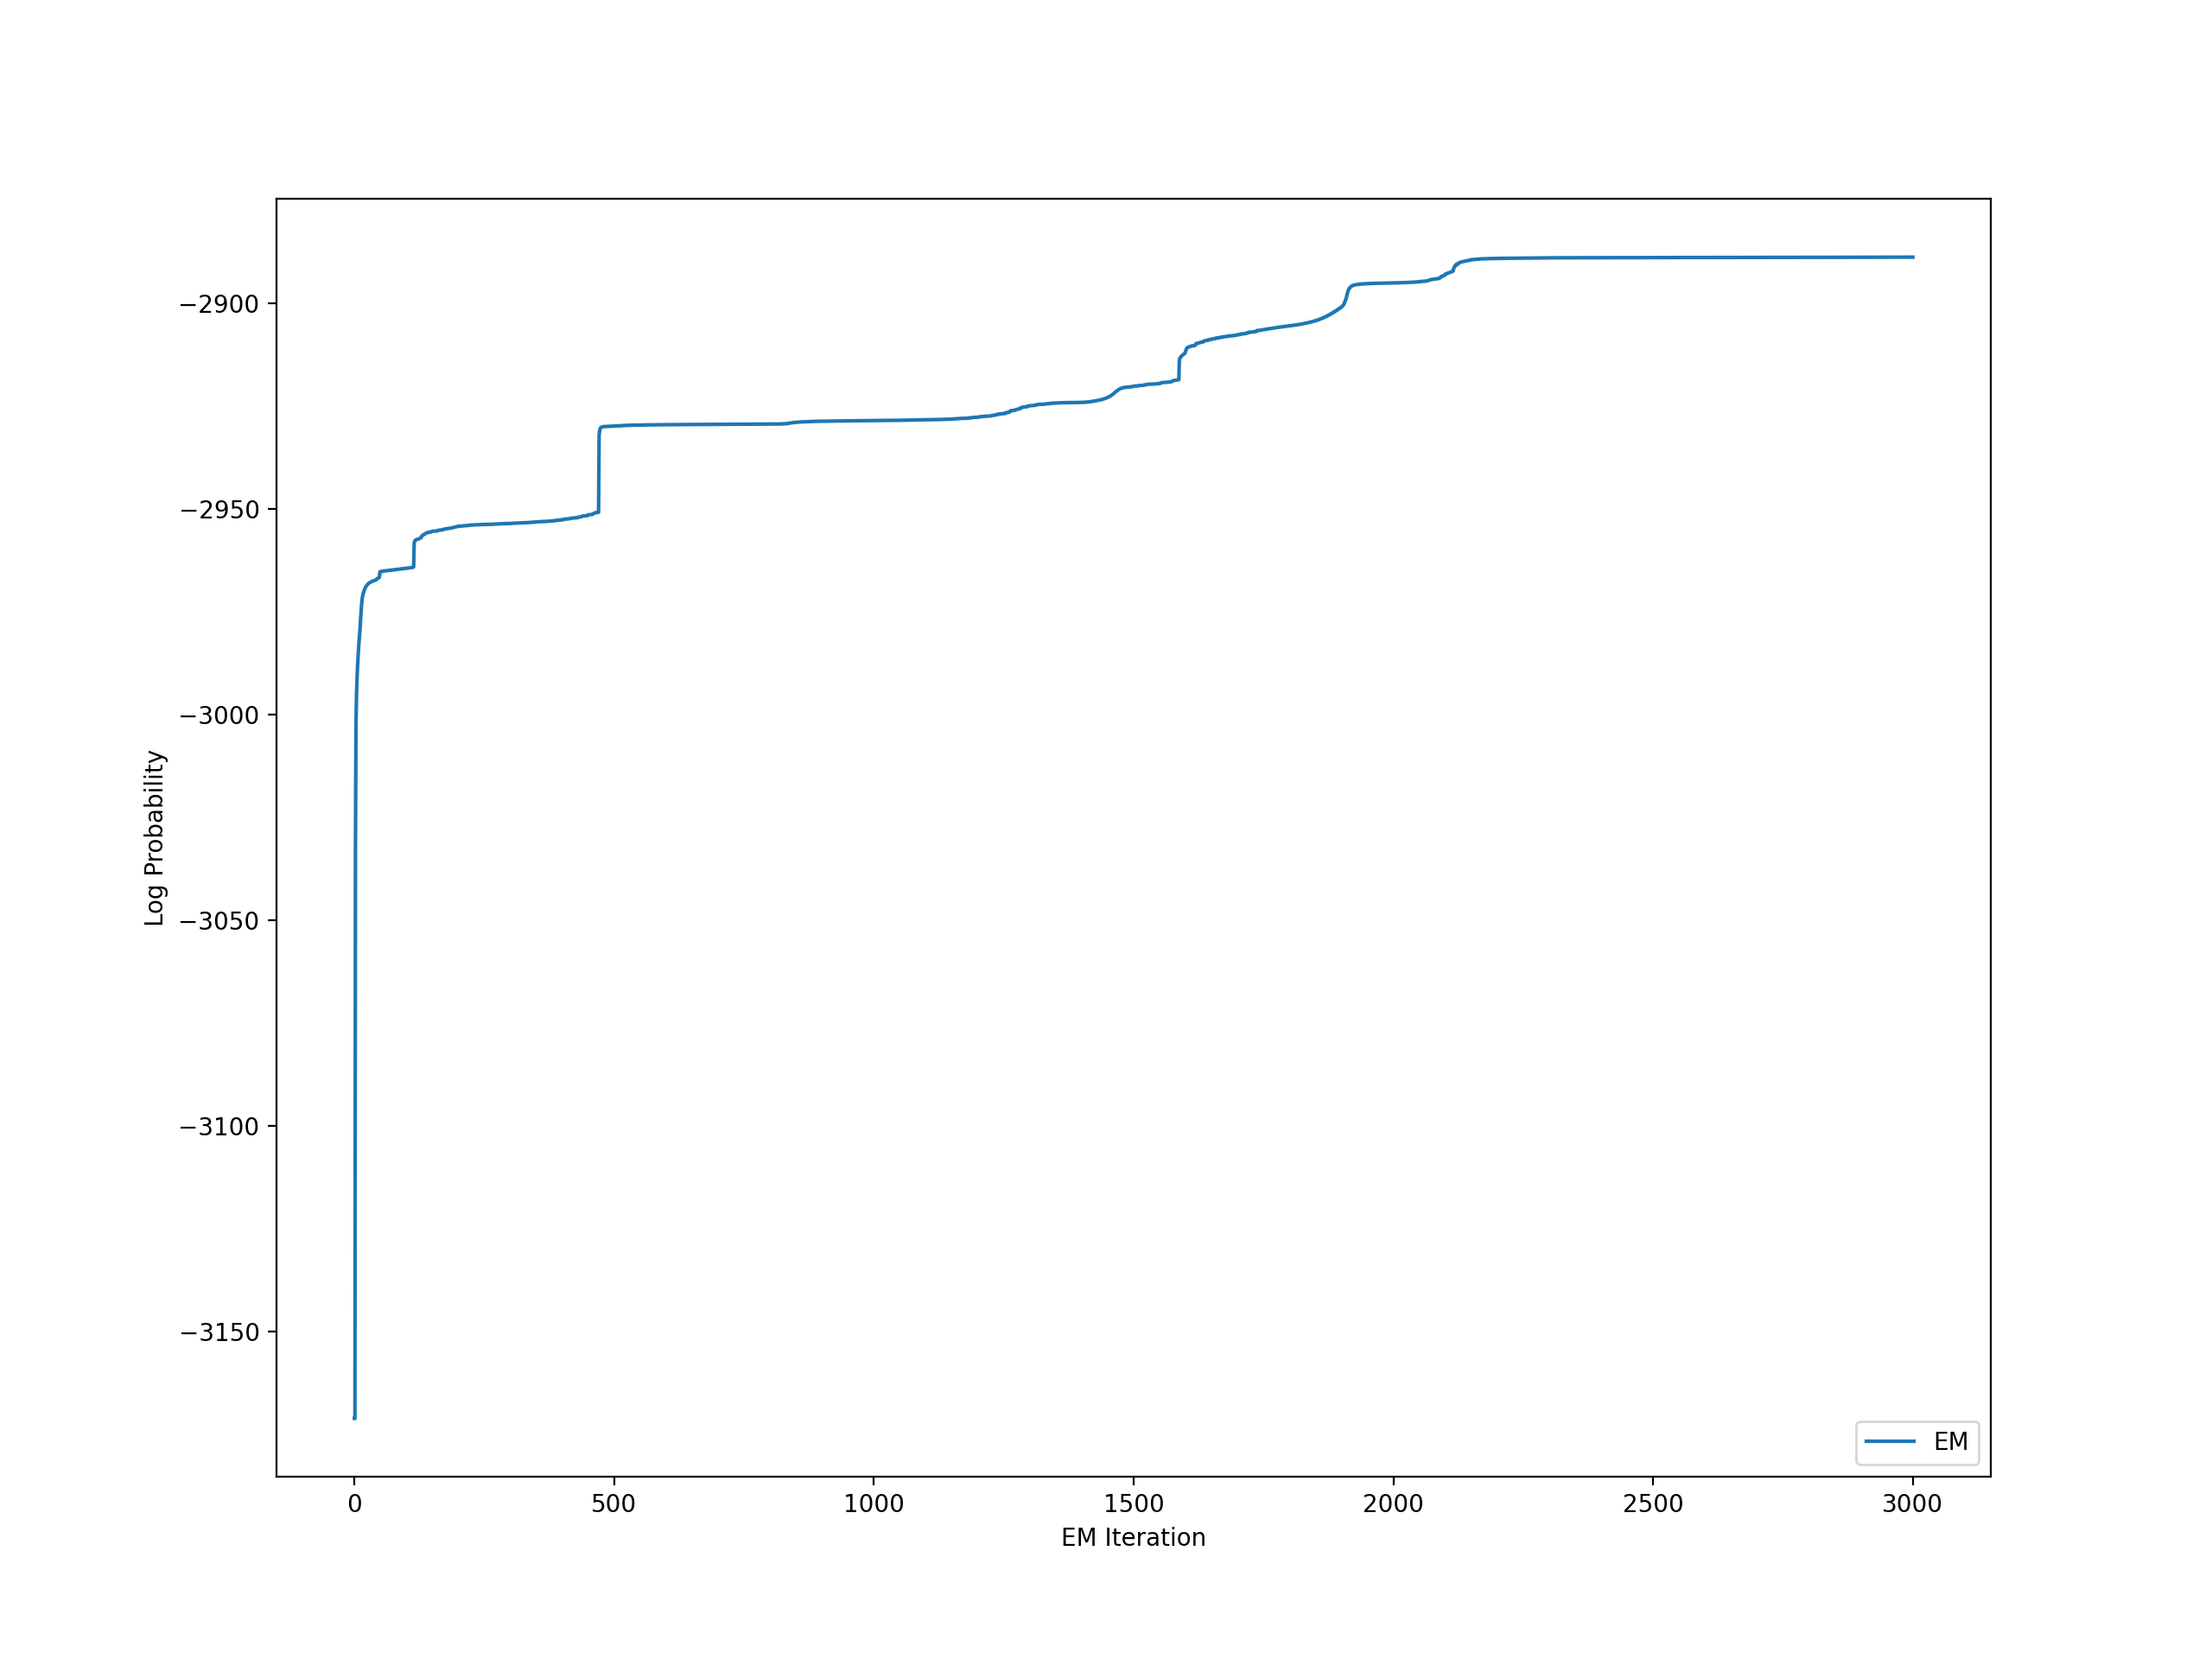

In [66]:
masks = ~np.isnan(obs)
obsmasked = obs[:]
obsmasked[~masks] = 1

N_iters = 3000
obs_dim = obs.shape[1]
num_states = 4
seed = 124
np.random.seed(seed)

## testing the constrained transitions class
hmm = ssm.HMM(num_states, obs_dim, observations="blocklapse")

hmm_lls = hmm.fit(obs, method="em", masks=masks, num_iters=N_iters, init_method="kmeans")

plt.figure()
plt.plot(hmm_lls, label="EM")
# plt.plot([0, N_iters], true_ll * np.ones(2), ':k', label="True")
plt.xlabel("EM Iteration")
plt.ylabel("Log Probability")
plt.legend(loc="lower right")
plt.show()

<IPython.core.display.Javascript object>


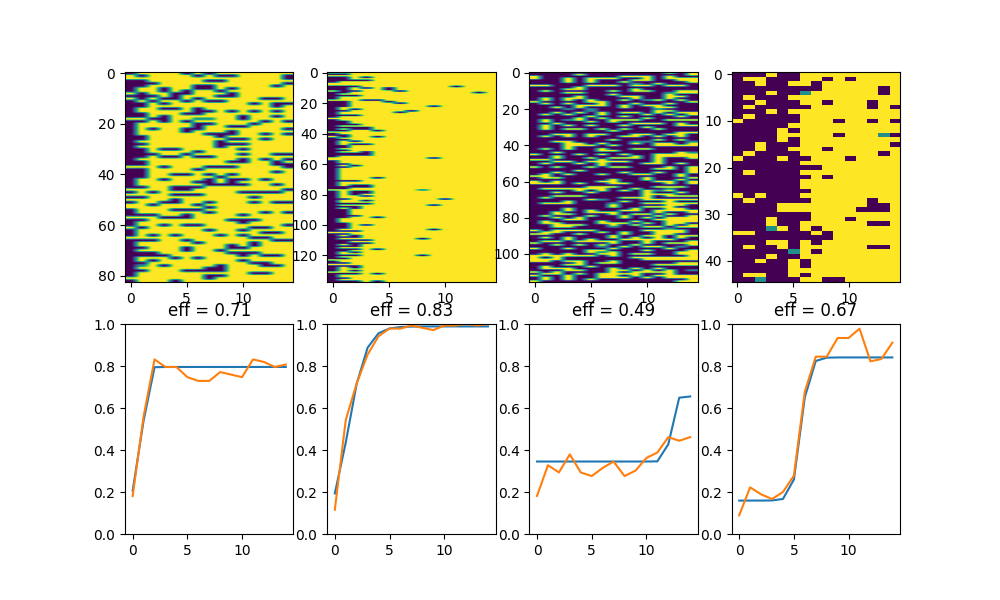

In [72]:
# perm_order = [2,1,0,3]
# hmm.permute(perm_order)

# Pool states and visualize
zstates = hmm.most_likely_states(obs)
obs_clustered = [obs[zstates == i, :] for i in np.unique(zstates)]

# Construct the block transition function for each mode
mus, sigmas, lapses = hmm.observations.params

transfuncs = [sigmoid(np.arange(15), mu, sigma, lapse) for mu, sigma, lapse in zip(mus, sigmas, lapses)]
plt.figure(figsize=(10,6))

effs = []

for i in range(num_states):
    # Find the average foraging efficiency of that state
    blen_state = np.array(block_lens)[zstates == i]
    bcorr_state = np.array(block_corrs)[zstates == i]
    eff_state = sum(bcorr_state) / sum(blen_state)
    effs.append(eff_state)
    
    plt.subplot(2,num_states,i+1)
    plt.imshow(obs_clustered[i], aspect='auto')
    
    plt.subplot(2, num_states, i+1+num_states)
    plt.plot(transfuncs[i])
    plt.plot(np.nanmean(obs_clustered[i], axis=0))
    plt.ylim([0, 1])
    
#     plt.title(f'mu={mus[i][0]:.2}, sigma={sigmas[i][0]:.2}, lapse={lapses[i][0]:.2}')
    plt.title(f'eff = {eff_state:.2}')


In [73]:
params = hmm.observations.params


In [74]:
params

(array([[ 0.95444187],
        [ 1.21707436],
        [12.20507787],
        [ 5.64825105]]),
 array([[5.9320238 ],
        [1.21417841],
        [4.97974393],
        [2.71712409]]),
 array([[0.20456992],
        [0.01154348],
        [0.34511244],
        [0.15919635]]))

In [69]:
np.sum(obs_clustered[1]) / np.prod(np.shape(obs_clustered[1]))

0.899298245614035

In [33]:
np.sum(np.array(block_corrs)[zstates == 1]) / np.sum(np.array(block_lens)[zstates == 1])

0.8930741190765492

In [32]:
np.array(block_lens)[zstates == 1]

array([ 2, 11, 20, 15, 11, 13, 11, 14, 15, 11, 10, 11, 11, 15, 10, 15, 14,
       11, 12, 14, 13, 11, 11, 12, 11, 15, 15, 11, 11, 14, 11, 14, 15, 12,
       15, 11, 11, 10, 10, 11, 11, 11, 13, 15, 15, 15, 11, 14, 13, 11, 13,
       11, 14, 15, 11, 14, 14, 10, 11, 12, 11, 10, 12, 10, 14, 11, 11])

<IPython.core.display.Javascript object>


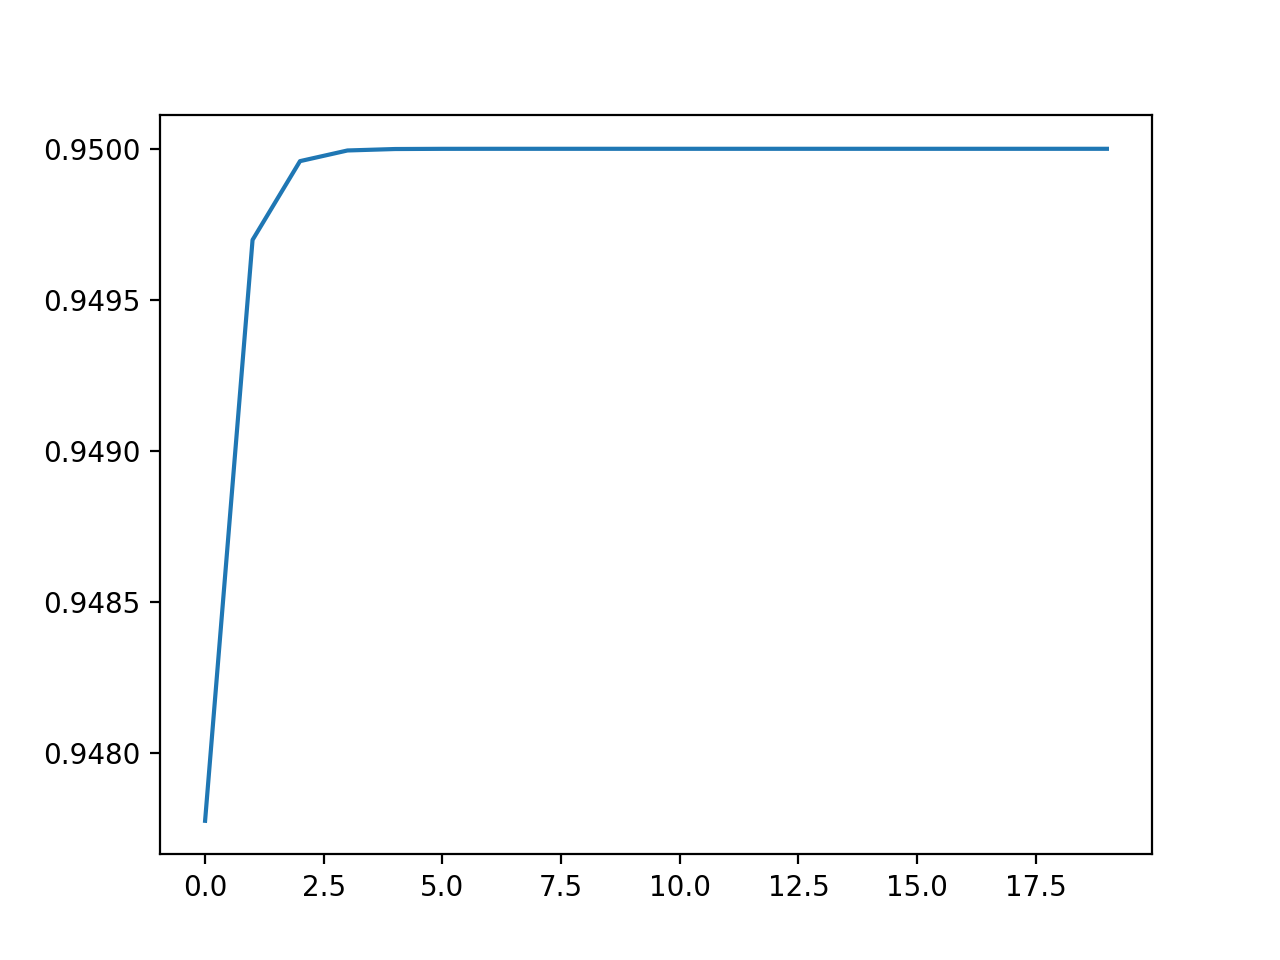

In [41]:
yvals = predict_sigmoid(np.arange(20), [2, 3, 0.05])
plt.plot(yvals)

In [56]:
def simulate_efficiency(params, ntrials=20):
    '''
    Given parameters of a sigmoidal function (slope, offset, lapse), simulate
    the efficiency of the agent in a block of ntrials trials
    '''
    delta = 0.1
    xvals = np.arange(0, int(ntrials), delta)
    yvals = predict_sigmoid(xvals, params)
    return np.sum(yvals) * delta / ntrials
    

In [75]:
simulate_efficiency([1.21, 1.21, 0.01], 20)

0.981106714316093

In [70]:
simulate_efficiency([2.61, 0.77, 0.01], 20)

0.9873380118749011

In [65]:
for i in zip(params[1], params[0], params[2]):
    eff = simulate_efficiency(i, ntrials=20)
    print(eff)

0.8548100825884262
0.9437089938610885
0.9565843858596963
0.9504694801092312
0.7462040146962924


In [64]:
params

(array([[16.56758515],
        [ 0.32534454],
        [ 3.87354042],
        [ 1.79244046],
        [10.24968866]]),
 array([[0.46415354],
        [4.8929244 ],
        [0.45044906],
        [5.10971877],
        [0.05600436]]),
 array([[0.14515414],
        [0.05420052],
        [0.02612708],
        [0.04952933],
        [0.01      ]]))